In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import DistilBertModel, RobertaModel
from flair.embeddings import TransformerDocumentEmbeddings
from umap import UMAP
from transformers import pipeline
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import re
import rubrix as rb
import json
pd.set_option("display.max_columns", None)
#pd.set_option('display.max_rows', 500)
pd.options.plotting.backend='plotly'

C:\HA\Python\Anaconda\lib\site-packages\jose\backends\cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


In [16]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli", device=0, framework='pt'
                     )

In [17]:
# Each line is 1 topic, 1 topic can have multiple keywords
labels = [
    'behavior', 'communication',
    'connection', 'network',
    'appointment',
    'membership',
    'disease', 'health',
    'waiting time', 'response time',
    'knowledge', 'expertise', 'solution', 'information', 'resources', 'answers',
    'registration',
    'interface',
    'price',
    'location',
    'search', 'navigation',
    'facilities', 'parking'
]

In [18]:
print(datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
pretrained_results = classifier(df['Text_Eng'].tolist(), labels, multi_label=True)
print(datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

11-02-2022 00:43:26
11-02-2022 02:59:58


In [19]:
def get_label_score_dict(row):
    result_dict = dict()
    for _label, _score in zip(row['labels'], row['scores']):
        result_dict.update({'sequence': row['sequence']})
        result_dict.update({_label: _score})
    return result_dict

In [20]:
pre_trained_df = pd.DataFrame([get_label_score_dict(pretrained_results[i]) for i in range(len(pretrained_results))])
#web_df = web_df[['sequence'] + candidate_labels]
pre_trained_df = pre_trained_df.join(df['Question'])
pre_trained_df.head(2)

,sequence,waiting time,communication,information,response time,solution,connection,interface,facilities,answers,knowledge,behavior,resources,location,health,network,navigation,expertise,registration,search,membership,appointment,parking,price,disease,Question
0,Apart from waiting time I was happy with call ...,0.966636,0.942084,0.842363,0.782357,0.768173,0.736106,0.691036,0.635290,0.625978,0.620564,0.499990,0.472937,0.466477,0.452279,0.446681,0.426475,0.405537,0.305370,0.230703,0.201517,0.185061,0.094796,0.080908,0.030103,QC1_2_3
1,The agent was able to accurately identify and ...,0.211771,0.806082,0.975619,0.959008,0.925889,0.838305,0.853247,0.780263,0.834695,0.931860,0.479501,0.598362,0.667333,0.709648,0.642477,0.682525,0.985570,0.512305,0.814492,0.281549,0.643295,0.469317,0.366693,0.121846,QC1_3


In [21]:
pre_trained_df.to_csv('data/pre_trained_df.csv',index=False)

# Handlabel data

In [2]:
pre_trained_df = pd.read_csv('data/pre_trained_df.csv')

In [3]:
handlabel_df = pre_trained_df.sample(500, random_state=42)

In [4]:
handlabel_df = pd.read_csv('data/handlabel.csv', index_col=0)
handlabel_df.head(2)

,sequence,communication_behavior,waiting time_response time,information_solution_knowledge_resources_expertise_answers,connection_network,interface,facilities_parking,location,health_disease,navigation_search,registration,membership,appointment,price,Question,sentiment
6784,satisfied with the answer,0,0,1,0,0,0,0,0,0,0,0,0,0,QC1_2_3,1
9368,Friendly employee,1,0,0,0,0,0,0,0,0,0,0,0,0,QE1_3,1


# Select thresholds using handlabelled data as truth

In [5]:
# To ensure the same rows are selected - handlabel_df was created by selecting random rows from the full df
pretrained_preds_df = pre_trained_df.loc[handlabel_df.index]

In [6]:
pretrained_preds_df['communication_behavior'] = pretrained_preds_df[['communication', 'behavior']].max(axis=1)
pretrained_preds_df['waiting time_response time'] = pretrained_preds_df[['waiting time', 'response time']].max(axis=1)
pretrained_preds_df['information_solution_knowledge_resources_expertise_answers'] = pretrained_preds_df[['information', 'solution', 'knowledge', 'resources', 'expertise', 'answers']].max(axis=1)
pretrained_preds_df['connection_network'] = pretrained_preds_df[['connection', 'network']].max(axis=1)
pretrained_preds_df['facilities_parking'] = pretrained_preds_df[['facilities', 'parking']].max(axis=1)
pretrained_preds_df['health_disease'] = pretrained_preds_df[['health', 'disease']].max(axis=1)
pretrained_preds_df['navigation_search'] = pretrained_preds_df[['navigation', 'search']].max(axis=1)

pretrained_preds_df = pretrained_preds_df[['sequence', 'communication_behavior',
       'waiting time_response time',
       'information_solution_knowledge_resources_expertise_answers',
       'connection_network', 'interface', 'facilities_parking',
       'location', 'health_disease', 'navigation_search',
       'registration', 'membership', 'appointment', 'price', 'Question']]

pretrained_preds_df.head(2)

,sequence,communication_behavior,waiting time_response time,information_solution_knowledge_resources_expertise_answers,connection_network,interface,facilities_parking,location,health_disease,navigation_search,registration,membership,appointment,price,Question
6784,satisfied with the answer,0.226601,0.797404,0.951567,0.683548,0.804489,0.582454,0.248252,0.439533,0.487144,0.324997,0.119510,0.337356,0.228590,QC1_2_3
9368,Friendly employee,0.885882,0.409536,0.860427,0.994167,0.828100,0.324818,0.190103,0.245348,0.595099,0.329471,0.030237,0.114794,0.053729,QE1_3


In [27]:
pretrained_preds_df.to_csv('data/subset_pretrained_preds_df.csv')

In [15]:
group_labels = ['communication_behavior',
       'waiting time_response time',
       'information_solution_knowledge_resources_expertise_answers',
       'connection_network', 'interface', 'facilities_parking',
       'location', 'health_disease', 'navigation_search',
       'registration', 'membership', 'appointment', 'price']

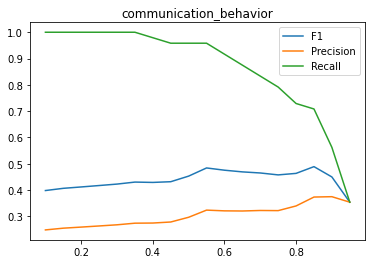

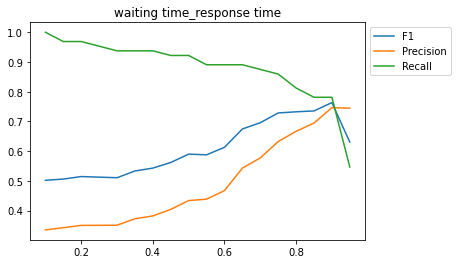

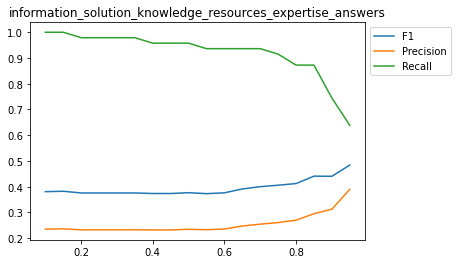

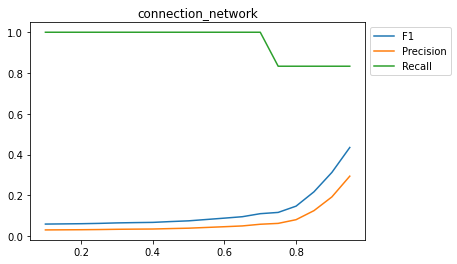

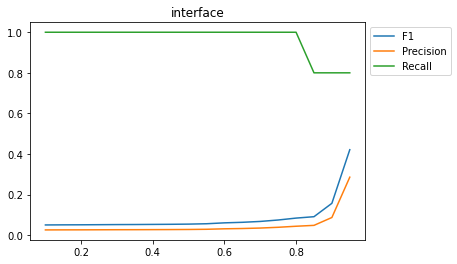

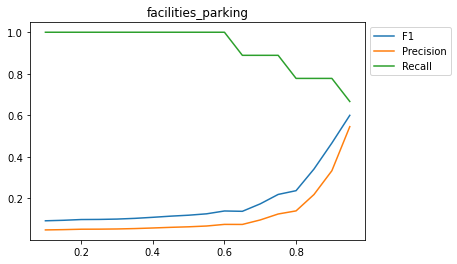

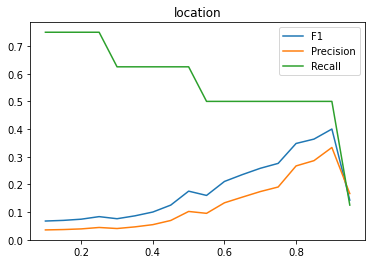

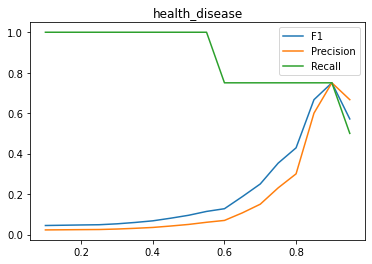

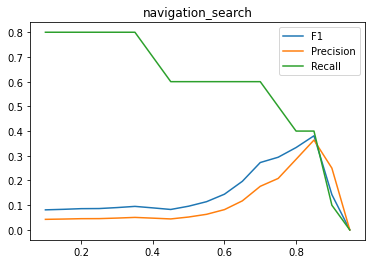

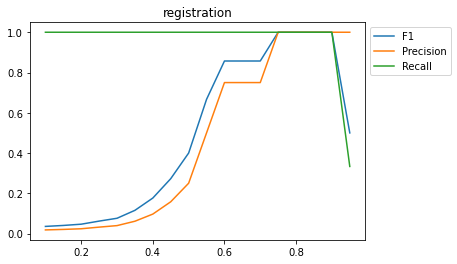

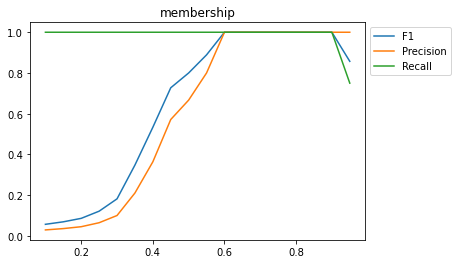

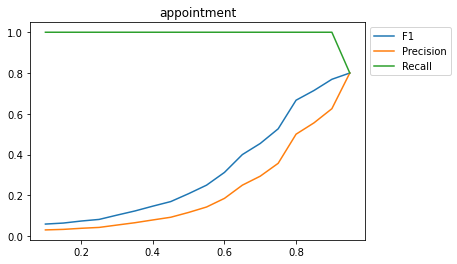

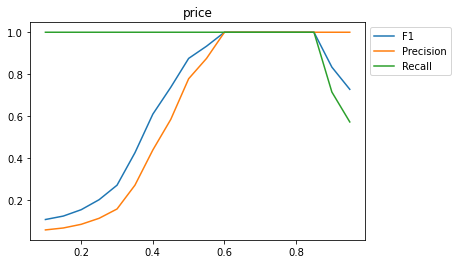

In [29]:
thresholds = np.arange(0.1, 1, 0.05)

for col in group_labels:
    f1_list = []
    precision_list = []
    recall_list = []
    
    for threshold in thresholds:    
        
        preds = pretrained_preds_df[col].apply(lambda x: 1 if x >= threshold else 0)
        f1_list.append(f1_score(y_true=handlabel_df[col], y_pred=preds))
        precision_list.append(precision_score(y_true=handlabel_df[col], y_pred=preds))
        recall_list.append(recall_score(y_true=handlabel_df[col], y_pred=preds))
        
    plt.figure()
    plt.plot(thresholds, f1_list, label='F1')
    plt.plot(thresholds, precision_list, label='Precision')
    plt.plot(thresholds, recall_list, label='Recall')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(col)
        

# Select threshold for each topic

In [12]:
group_labels_threshold = {
 'communication_behavior': 0.85,
 'waiting time_response time': 0.9,
 'information_solution_knowledge_resources_expertise_answers': 0.8, #manually updated
 'connection_network': 0.95,
 'interface': 0.95,
 'facilities_parking': 0.95,
 'location': 0.9,
 'health_disease': 0.9,
 'navigation_search': 0.85,
 'registration': 0.9,
 'membership': 0.9,
 'appointment': 0.95,
 'price': 0.85
}

with open('data/topic_thresholds.json', 'w') as fp:
    json.dump(group_labels_threshold, fp)

# Explore misclassifications

In [13]:
for col in group_labels_threshold.keys():
    pretrained_preds_df[col] = pretrained_preds_df[col].apply(lambda x: 1 if x >= group_labels_threshold[col] else 0)

In [19]:
misclass = handlabel_df[['sequence']+group_labels].merge(pretrained_preds_df[['sequence']+group_labels], how='inner', on='sequence',
                                                        suffixes=('_true', '_pred'))

misclass.to_excel('data/for_leo.xlsx', index=False)

In [22]:
misclass[misclass['sequence'].str.contains('layout')].values

array([['I am satisfied because the carry-in service location implements strict health protocols, the layout of the room is amazing and clean, and the courtesy of the staff there and they focus on the needs of consumers',
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0]], dtype=object)